<a href="https://colab.research.google.com/github/Kyeongbin-Tom/logp-tpsa-analysis/blob/main/notebooks/LogP_TPSA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Project Overview

This project investigates the correlation between molecular lipophilicity (LogP) and topological polar surface area (TPSA) using cheminformatics techniques.

It shows how a chemical hypothesis can be validated by Python-based data analysis using RDKit, and machine learning tools.

## 🛠️ SRC

To keep the notebook concise, modular, and maintainable, we separate reusable fuctions into the `/src` folder.

 - `src/descriptors.py` defines 'smiles_to_descriptors(smiles)', which calculates five molecular descriptors from a SMILES string:
  **TPSA**, **Molecular Weight**, **Number of H-bond Acceptors**, **Number of H-bond Donors**, and **Number of Rotatable Bonds**.

 - `src/visualization.py` contains
  - `plot_distribution(df, col)`: plots a histogram of the descriptors
  - `plot_tpsa_vs_logp(df)`: creates a scatter plot of LogP VS TPSA

## ⚙️ Setup

We configure the environment for compatibility with RDKit and custom modules. RDKit is used for molecular descriptor calculation.NumPy must be downgraded to ≤ 1.23 for RDKit compatibility in Google Colab. We add `/src` to the Python path to enable importing `descriptors.py` and `visualization.py`.

⚠️ **Note**: You may need to restart the runtime after installing RDKit in Colab.

In [ ]:
# ✅ [Setup Step 1] Downgrade numpy (RDKit compatibility fix)
# Must restart Colab runtime after this cell!
!pip install -q numpy==1.26.4

# Force Colab runtime restart
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# ✅ [Setup Step 2] Install RDKit and load custom Python modules from GitHub

# Install RDKit (after numpy is downgraded)
!pip install -q rdkit-pypi

# Download src/ modules from GitHub
!rm -rf src
!mkdir -p src
!wget -q https://raw.githubusercontent.com/Kyeongbin-Tom/logp-tpsa-analysis/main/src/descriptors.py -O src/descriptors.py
!wget -q https://raw.githubusercontent.com/Kyeongbin-Tom/logp-tpsa-analysis/main/src/visualization.py -O src/visualization.py

# Import functions from src/
import sys
sys.path.append('/content/src')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.7 MB/s eta 0:00:00


## 📦 Import Libraries

We import all required libraries for descriptor calculation, visualization, and machine learning model training.

This includes:
- `RDKit` for chemical structure handling
- `pandas`, `matplotlib`, `seaborn` for data analysis and visualization
- `scikit-learn` for modeling and evaluation
- Custom modules from `src/`: `descriptors.py` and `visualization.py`

In [11]:
# Custom modules
from descriptors import smiles_to_descriptors
from visualization import plot_tpsa_vs_logp, plot_distribution

# General-purpose libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


## 📁 Dataset Overview

We use `Lipophilicity.csv` from the CAIP repository, which contains molecular structures represented as SMILES strings along with experimentally measured lipophilicity (LogP) values.

This dataset serves as foundation for feature extraction, correlation analysis, and predictive modeling.

In [3]:
from google.colab import files
uploaded=files.upload()

Saving Lipophilicity.csv to Lipophilicity.csv


In [4]:
# Enter the correct file name (Check auto-generated name!)
df = pd.read_csv("Lipophilicity.csv")

# Check the top 5 rows
df.head()

,SMILES,Lipophilicity
0,Brc1c[nH]c(=NCc2ccccc2)nc1N=c1cc(C2CC2)[nH][nH]1,4.11
1,Brc1cc(Br)cc(COC[C@H](c2ccccc2)N2CCNCC2)c1,2.80
2,C#CC(C)(C)NC(=O)c1sccc1Oc1ccc(F)cc1[N+](=O)[O-],3.00
3,C#CC(C)n1c(=O)c2c(-c3cncn3C)n(Cc3ccnc4ccc(Cl)c...,3.59
4,C#CCC(C(=O)N=C(Cc1cc[nH]c1O)CCC(O)OCC)n1cccc(N...,1.75


## 🧪 Molecular Descriptor Extraction

We calculate the TPSA (Topological Polar Surface Area), which represents the size of the polar region, using RDKit through a custom function `smiles_to_descriptors(smiles)`.

This descriptor will be used as an input for correlation analysis and machine learning. We also check for invalid SMILES strings that may result in missing (NaN) values.

In [5]:
# Calculate TPSA from SMILES using custom descriptor function
df['TPSA'] = df['SMILES'].apply(smiles_to_descriptors)

# Check for any NaN values (invalid SMILES)
print("Missing TPSA values:", df['TPSA'].isna().sum())

Missing TPSA values: 0


In [6]:
# Load the dataset
df = pd.read_csv("Lipophilicity.csv")

# Generate molecular descriptors (TPSA, MolWt, HBD, HBA, RotatableBonds) from SMILES
desc_df = df['SMILES'].apply(smiles_to_descriptors).apply(pd.Series)

# Merge descriptors into original dataframe
df = pd.concat([df, desc_df], axis=1)

# Remove duplicate columns if the cell is re-run
df = df.loc[:, ~df.columns.duplicated()]

## 📈 Feature Distribution

We plot histograms for each descriptor of distribution and correlation for LogP and TPSA to explore their distribution, range, and variance.

A scatter plot of TPSA versus LogP reveals a potential negative correlation. Pearson correlation coefficient between LogP and TPSA is approximately -0.14.

The plot is saved as images/tpsa_vs_logp.png for use in the README.

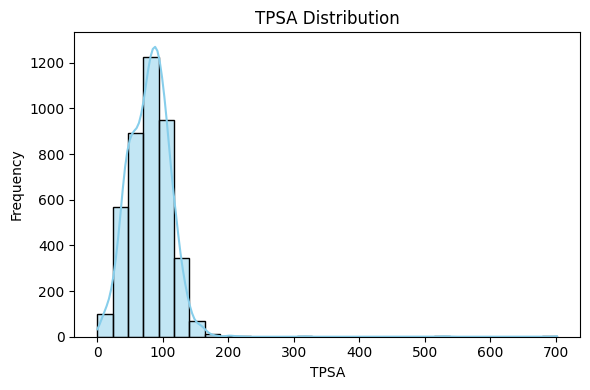

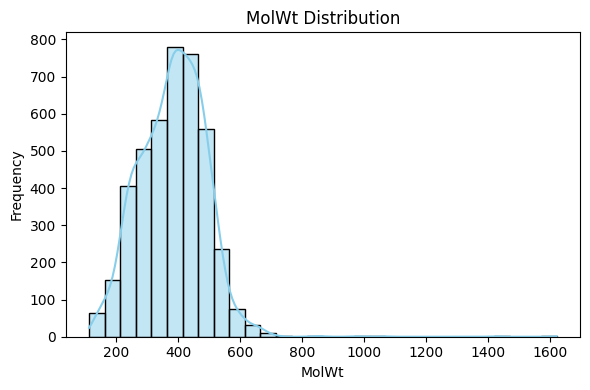

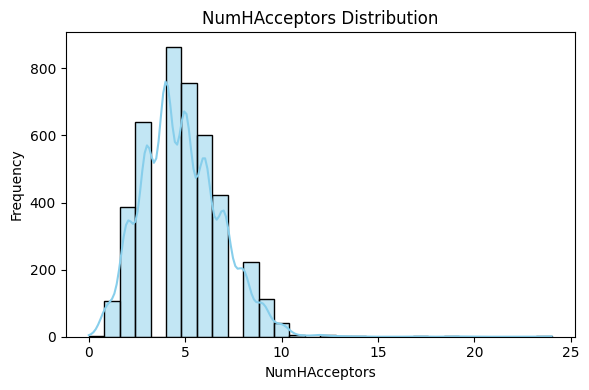

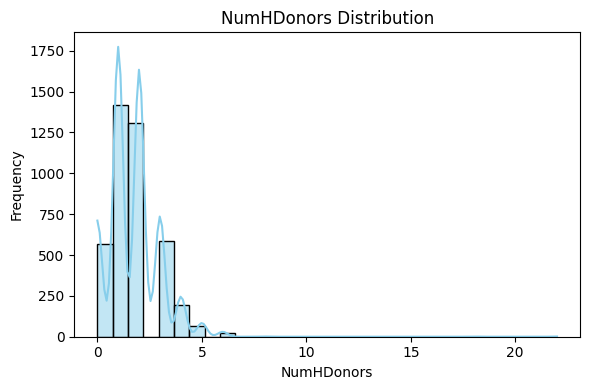

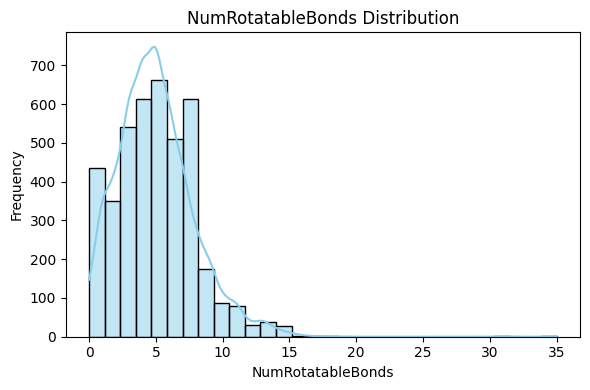

In [7]:
# Plot distribution histograms for each molecular descriptor
for col in ['TPSA', 'MolWt', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds']:
    plot_distribution(df, col, title=f"{col} Distribution")

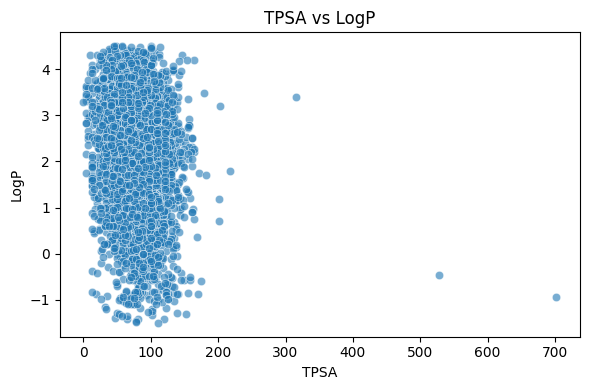

In [12]:
# Scatter plot: TPSA vs LogP
os.makedirs('images', exist_ok=True)
plot_tpsa_vs_logp(
    df,
    save_path='images/tpsa_vs_logp.png'
)

In [13]:
# Check Pearson correlation between TPSA and Lipophilicity
df[['TPSA', 'Lipophilicity']].corr(method='pearson')

,TPSA,Lipophilicity
TPSA,1.000000,-0.142139
Lipophilicity,-0.142139,1.000000


## 🤖 LogP Prediction using SVR



In [ ]:
X = df[['TPSA', 'MolWt', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds']]
y = df['Lipophilicity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.12564381468340857
MSE: 1.4123069733730527


In [ ]:
# Convert SMILES to Mol objects
df["Mol"] = df["SMILES"].apply(Chem.MolFromSmiles)


In [ ]:
def compute_descriptors(mol):
    # If SMILES is invalid and the Mol object cannot be created (None),
    # Return all features as None to prevent errors
    if mol is None:
        return pd.Series({
            "MolWt": None,                # Molecular weight
            "TPSA": None,                 # Topological Polar Surface Area
            "NumHDonors": None,           # Number of hydrogen bond donors
            "NumHAcceptors": None,        # Number of hydrogen bond acceptors
            "NumRotatableBonds": None,    # Number of rotatable bonds
            "RingCount": None,            # Number of rings
            "AromaticProportion": None    # Proportion of aromatic atoms
        })

   # If the Mol object is successfully created, calculate features using RDKit
    return pd.Series({
    "MolWt": Descriptors.MolWt(mol),                              # Calculate molecular weight
    "TPSA": rdMolDescriptors.CalcTPSA(mol),                       # Calculate topological polar surface area (TPSA)
    "NumHDonors": rdMolDescriptors.CalcNumHBD(mol),              # Calculate number of H-bond donors
    "NumHAcceptors": rdMolDescriptors.CalcNumHBA(mol),           # Calculate number of H-bond acceptors
    "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),     # Calculate number of rotatable bonds
    "RingCount": rdMolDescriptors.CalcNumRings(mol),             # Calculate number of rings
    "AromaticProportion": len([atom for atom in mol.GetAromaticAtoms()]) / mol.GetNumAtoms()    # Proportion of aromatic atoms = number of aromatic atoms / total number of atoms
})

In [ ]:
# Apply the compute_descriptors function to all molecules (Mol objects) in df["Mol"]
# The result is stored in a new DataFrame called descriptor_df, with each molecular feature as a column
descriptor_df = df["Mol"].apply(compute_descriptors)

In [ ]:
# Concatenate the original df and the computed descriptor_df side by side (axis=1)
# The resulting df_full includes SMILES, logP, Mol objects, and all molecular descriptors
df_full = pd.concat([df, descriptor_df], axis=1)

In [ ]:
# Display the first 5 rows of df_full to verify that the descriptors were calculated correctly
df_full.head()

,SMILES,Lipophilicity,TPSA,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,Mol,MolWt,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,RingCount,AromaticProportion
0,Brc1c[nH]c(=NCc2ccccc2)nc1N=c1cc(C2CC2)[nH][nH]1,4.11,84.98,385.269,3.0,3.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x7cef76b9ad50>,385.269,84.98,3.0,3.0,4.0,4.0,0.708333
1,Brc1cc(Br)cc(COC[C@H](c2ccccc2)N2CCNCC2)c1,2.80,24.50,454.206,3.0,1.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x7cef76b9ae30>,454.206,24.50,1.0,3.0,6.0,3.0,0.500000
2,C#CC(C)(C)NC(=O)c1sccc1Oc1ccc(F)cc1[N+](=O)[O-],3.00,81.47,348.355,5.0,1.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x7cef76b9aea0>,348.355,81.47,1.0,5.0,5.0,2.0,0.458333
3,C#CC(C)n1c(=O)c2c(-c3cncn3C)n(Cc3ccnc4ccc(Cl)c...,3.59,92.53,513.989,9.0,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x7cef76b9af10>,513.989,92.53,0.0,9.0,6.0,6.0,0.648649
4,C#CCC(C(=O)N=C(Cc1cc[nH]c1O)CCC(O)OCC)n1cccc(N...,1.75,172.04,523.546,9.0,4.0,12.0,<rdkit.Chem.rdchem.Mol object at 0x7cef76b9af80>,523.546,172.04,4.0,9.0,12.0,3.0,0.421053


In [ ]:
# Select only the numerical columns for correlation analysis
numeric_cols = ["Lipophilicity", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
                "NumRotatableBonds", "RingCount", "AromaticProportion"]

# Compute the correlation matrix among selected numerical descriptors
corr_matrix = df_full[numeric_cols].corr()

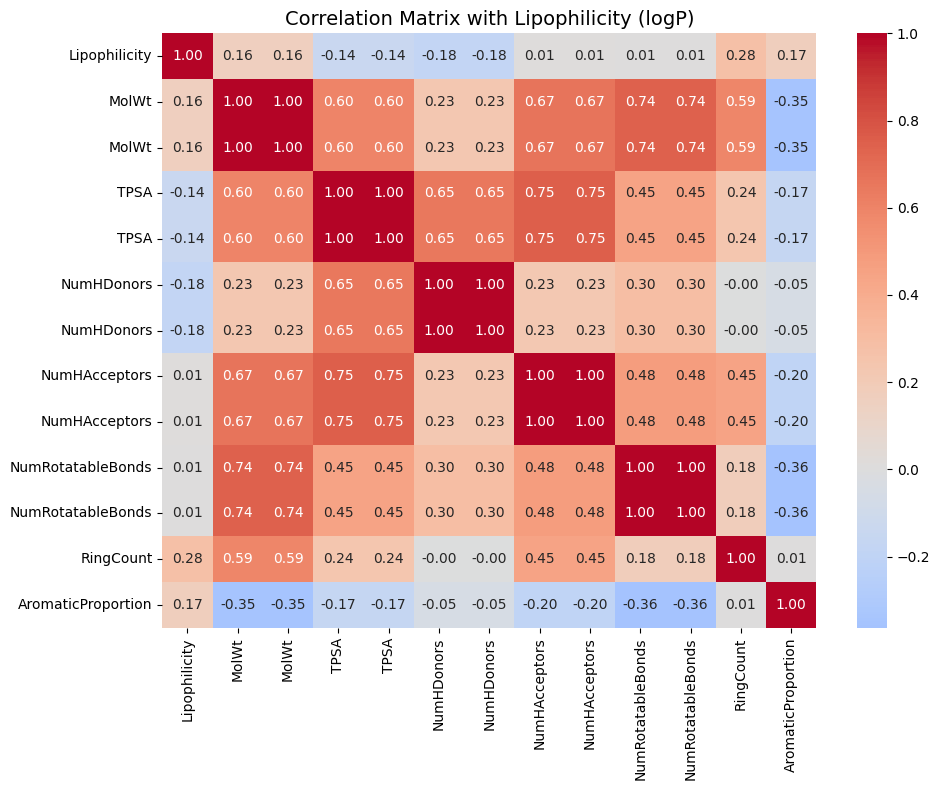

In [ ]:
# Set figure size for heatmap visualization
plt.figure(figsize=(10, 8))

# Draw a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

# Add title to the heatmap
plt.title("Correlation Matrix with Lipophilicity (logP)", fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

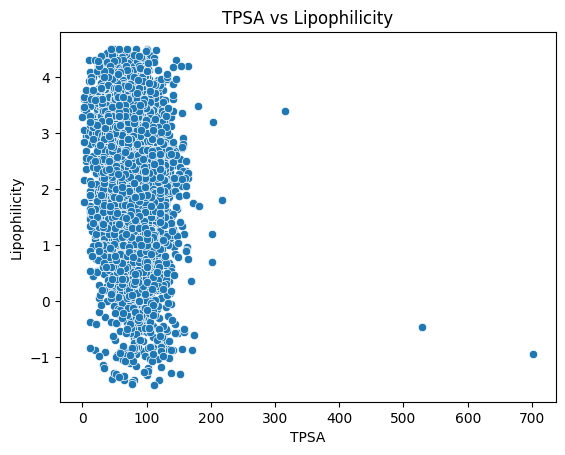

In [ ]:
# Example: Scatter plot between TPSA and Lipophilicity (logP)
sns.scatterplot(data=df, x="TPSA", y="Lipophilicity")
plt.title("TPSA vs Lipophilicity")
plt.show()

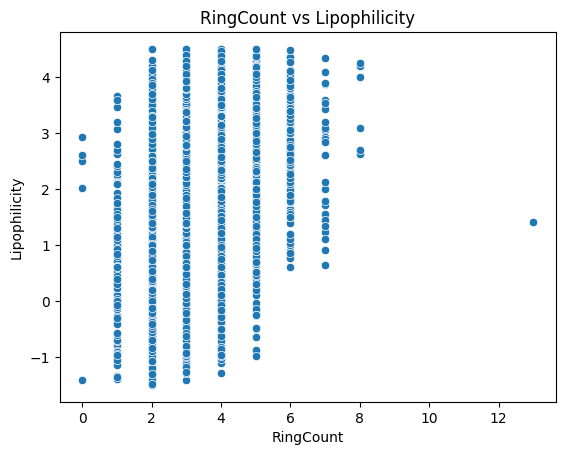

In [ ]:
# Example: Scatter plot between ringcount and Lipophilicity (logP)
sns.scatterplot(data=df_full, x="RingCount", y="Lipophilicity")
plt.title("RingCount vs Lipophilicity")
plt.show()

In [ ]:
df_full = df_full.loc[:, ~df_full.columns.duplicated()]

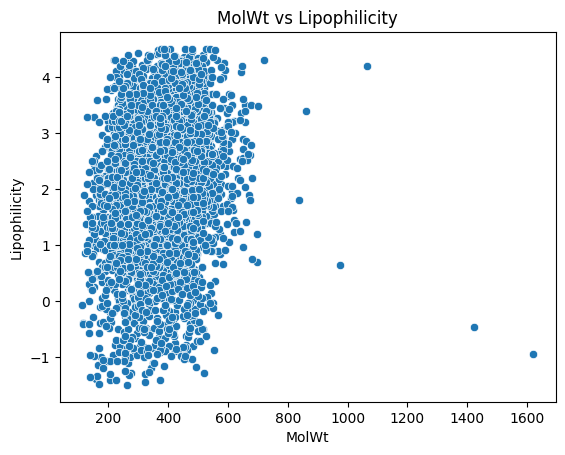

In [ ]:
# Example: Scatter plot between MolWt and Lipophilicity (logP)
sns.scatterplot(data=df_full, x="MolWt", y="Lipophilicity")
plt.title("MolWt vs Lipophilicity")
plt.show()

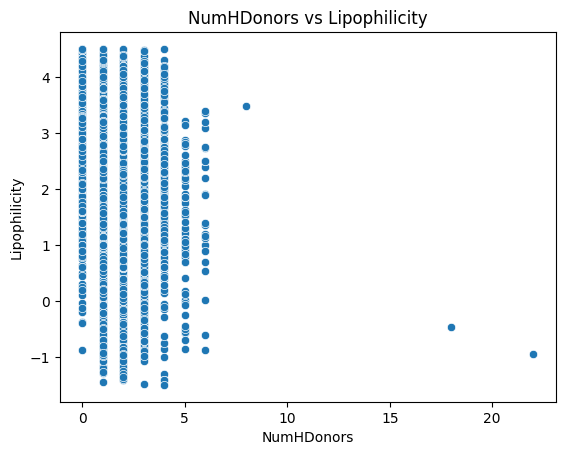

In [ ]:
# Example: Scatter plot between NumHDonors and Lipophilicity (logP)
sns.scatterplot(data=df_full, x="NumHDonors", y="Lipophilicity")
plt.title("NumHDonors vs Lipophilicity")
plt.show()

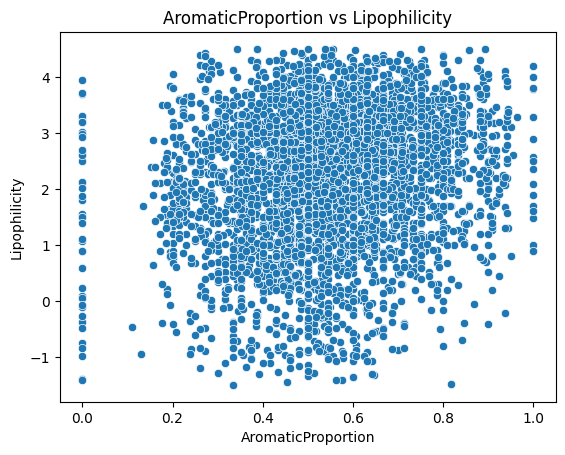

In [ ]:
# Example: Scatter plot between AromaticProportion and Lipophilicity (logP)
sns.scatterplot(data=df_full, x="AromaticProportion", y="Lipophilicity")
plt.title("AromaticProportion vs Lipophilicity")
plt.show()

In [ ]:
# List of numerical columns to include in the correlation analysis
numeric_cols = ["Lipophilicity", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
                "NumRotatableBonds", "RingCount", "AromaticProportion"]
print(df.columns.tolist())
# Compute the correlation matrix
# corr_matrix = df[numeric_cols].corr()
# df[numeric_cols]

['SMILES', 'Lipophilicity', 'TPSA', 'MolWt', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'Mol']


In [ ]:
# Calculate molecular weight (MolWt)
df['MolWt'] = df['SMILES'].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))

# Calculate number of hydrogen bond donors
df['NumHDonors'] = df['SMILES'].apply(lambda s: Descriptors.NumHDonors(Chem.MolFromSmiles(s)))

# Calculate number of hydrogen bond acceptors
df['NumHAcceptors'] = df['SMILES'].apply(lambda s: Descriptors.NumHAcceptors(Chem.MolFromSmiles(s)))

# Calculate number of rotatable bonds
df['NumRotatableBonds'] = df['SMILES'].apply(lambda s: Descriptors.NumRotatableBonds(Chem.MolFromSmiles(s)))

# Calculate number of rings in the molecule
df['RingCount'] = df['SMILES'].apply(lambda s: Descriptors.RingCount(Chem.MolFromSmiles(s)))

In [ ]:
# Custom function: Calculate aromatic atom proportion manually
# (Not available in RDKit Descriptors module)

def calc_aromatic_proportion(mol):
    # Skip if molecule is invalid
    if mol is None:
        return None

    # Count aromatic atoms (e.g. aromatic carbons, nitrogens, etc.)
    aromatic_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic())

    # Count all heavy atoms (excluding hydrogen)
    heavy_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() > 1)

    # Avoid division by zero
    if heavy_atoms == 0:
        return 0

    # Return ratio of aromatic atoms to total heavy atoms
    return aromatic_atoms / heavy_atoms

In [ ]:
# Convert SMILES strings to RDKit Mol objects
df["mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Calculate aromatic proportion from Mol objects
df["AromaticProportion"] = df["mol"].apply(calc_aromatic_proportion)

In [ ]:
# List of numerical columns to include in the correlation analysis
numeric_cols = ["Lipophilicity", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
                "NumRotatableBonds", "RingCount", "AromaticProportion"]

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()
df[numeric_cols]

# Extract correlation values between logP and all other descriptors
logp_corr = corr_matrix["Lipophilicity"].drop("Lipophilicity")

# Sort correlations by absolute value (no reindex needed)
logp_corr_sorted = logp_corr.sort_values(key=lambda x: x.abs(), ascending=False)

# Print sorted correlations
print("Correlation with logP (sorted by absolute value):")
print(logp_corr_sorted)

Correlation with logP (sorted by absolute value):
RingCount             0.280626
NumHDonors           -0.184621
AromaticProportion    0.172937
MolWt                 0.159188
TPSA                 -0.142139
NumHAcceptors         0.012929
NumRotatableBonds     0.006875
Name: Lipophilicity, dtype: float64


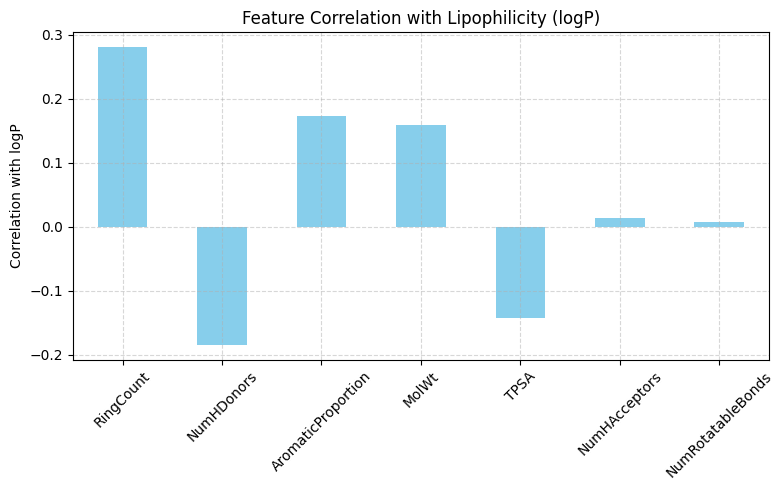

In [ ]:
# Set figure size
plt.figure(figsize=(8,5))

# Plot sorted correlation values as a bar chart
logp_corr_sorted.plot(kind='bar', color='skyblue')

# Labeling and styling
plt.ylabel("Correlation with logP")
plt.title("Feature Correlation with Lipophilicity (logP)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

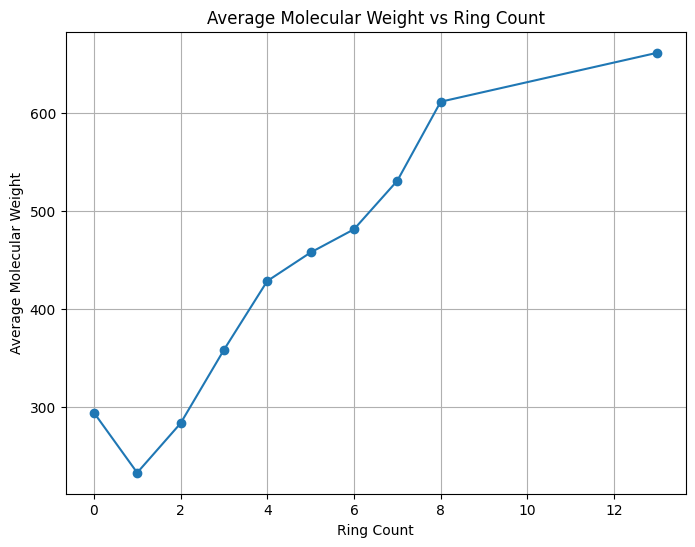

In [ ]:
# 1) Read SMILES strings from the CSV file
df = pd.read_csv('Lipophilicity.csv')

# 2) Convert SMILES strings to RDKit Mol objects
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# 3) Compute descriptors only if the Mol object is not None
df['MolWt'] = df['Mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol is not None else None)
df['RingCount'] = df['Mol'].apply(lambda mol: mol.GetRingInfo().NumRings() if mol is not None else None)

# 4) Optionally remove rows where Mol object creation failed
df = df[df['Mol'].notnull()].copy()

# 5) Calculate average MolWt for each RingCount group
mean_df = df.groupby('RingCount')['MolWt'].mean().reset_index()

# 6) Plot a line graph
plt.figure(figsize=(8,6))
plt.plot(mean_df['RingCount'], mean_df['MolWt'], marker='o', linestyle='-')
plt.title('Average Molecular Weight vs Ring Count')
plt.xlabel('Ring Count')
plt.ylabel('Average Molecular Weight')
plt.grid(True)
plt.show()

In [ ]:
# Load the dataset
df = pd.read_csv("Lipophilicity.csv")

# Convert SMILES strings to RDKit Mol objects
df["Mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Calculate molecular descriptors only if Mol object is not None
df["MolWt"] = df["Mol"].apply(lambda mol: Descriptors.MolWt(mol) if mol is not None else None)
df["TPSA"] = df["Mol"].apply(lambda mol: rdMolDescriptors.CalcTPSA(mol) if mol is not None else None)
df["NumHDonors"] = df["Mol"].apply(lambda mol: rdMolDescriptors.CalcNumHBD(mol) if mol is not None else None)
df["NumHAcceptors"] = df["Mol"].apply(lambda mol: rdMolDescriptors.CalcNumHBA(mol) if mol is not None else None)
df["NumRotatableBonds"] = df["Mol"].apply(lambda mol: Descriptors.NumRotatableBonds(mol) if mol is not None else None)
df["RingCount"] = df["Mol"].apply(lambda mol: mol.GetRingInfo().NumRings() if mol is not None else None)
df["AromaticProportion"] = df["Mol"].apply(
    lambda mol: len([atom for atom in mol.GetAromaticAtoms()]) / mol.GetNumAtoms()
    if mol is not None else None
)

# Remove rows with missing values (use only complete feature sets)
df = df.dropna(subset=["MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
                       "NumRotatableBonds", "RingCount", "AromaticProportion", "Lipophilicity"])

# Define input features and target variable
X = df[["MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
        "NumRotatableBonds", "RingCount", "AromaticProportion"]]  # input features
y = df["Lipophilicity"]  # target: measured lipophilicity (logP)

# Split the data into training and testing sets (20% for testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("Mean Squared Error (MSE):", round(mse, 4))
print("R² Score (R-squared):", round(r2, 4))

# Print regression coefficients to see the influence of each feature
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nFeature importance (by absolute coefficient):")
print(coeff_df)

Mean Squared Error (MSE): 1.2621
R² Score (R-squared): 0.2186

Feature importance (by absolute coefficient):
              Feature  Coefficient
6  AromaticProportion     1.656018
5           RingCount     0.065417
4   NumRotatableBonds    -0.063425
3       NumHAcceptors     0.040532
1                TPSA    -0.014866
2          NumHDonors     0.013396
0               MolWt     0.005716


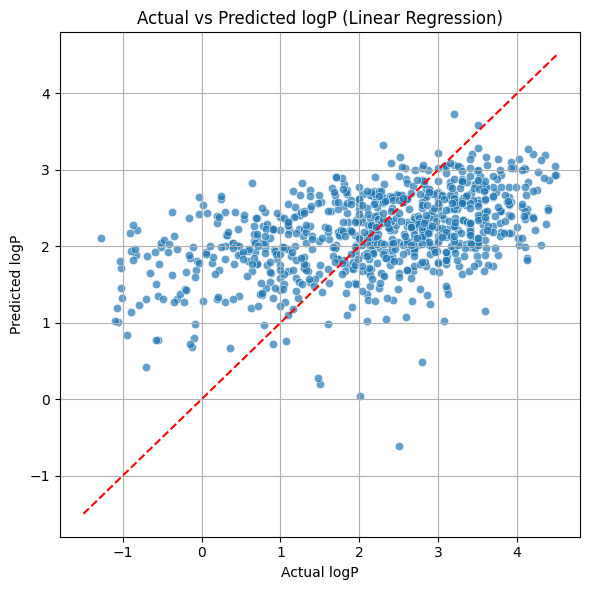

In [ ]:
# 1. Set figure size (6x6 inches)
plt.figure(figsize=(6,6))

# 2. Plot actual (y_test) vs predicted (y_pred) values as a scatter plot
# alpha=0.7 → Adjust transparency to show overlapping points more clearly
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)

# 3. Red dashed line: reference line for perfect prediction (y = x)
# If actual and predicted values are equal, all points will lie on this line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

# 4. Set axis labels and plot title
plt.xlabel("Actual logP")   # x-axis: experimentally measured logP
plt.ylabel("Predicted logP")  # y-axis: logP predicted by the model
plt.title("Actual vs Predicted logP (Linear Regression)")

# 5. Add grid and adjust layout
plt.grid(True)         # 배경에 격자선 추가
plt.tight_layout()     # 그래프 내부 여백 자동 조정

# 6. Display the plot
plt.show()

In [ ]:
# 1. Define the model
# - n_estimators: number of trees (100 is usually sufficient)
# - random_state: fixed for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# 4. Evaluate model performance
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# 5. Print evaluation results
print("Random Forest Regressor Results")
print("MSE:", round(rf_mse, 4))
print("R² Score:", round(rf_r2, 4))

# 6. Print feature importance scores
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\\nFeature Importance:")
print(feature_importance)

Random Forest Regressor Results
MSE: 0.9027
R² Score: 0.4412
\nFeature Importance:
              Feature  Importance
1                TPSA    0.241788
0               MolWt    0.228512
6  AromaticProportion    0.173987
5           RingCount    0.130892
4   NumRotatableBonds    0.081427
2          NumHDonors    0.075081
3       NumHAcceptors    0.068312


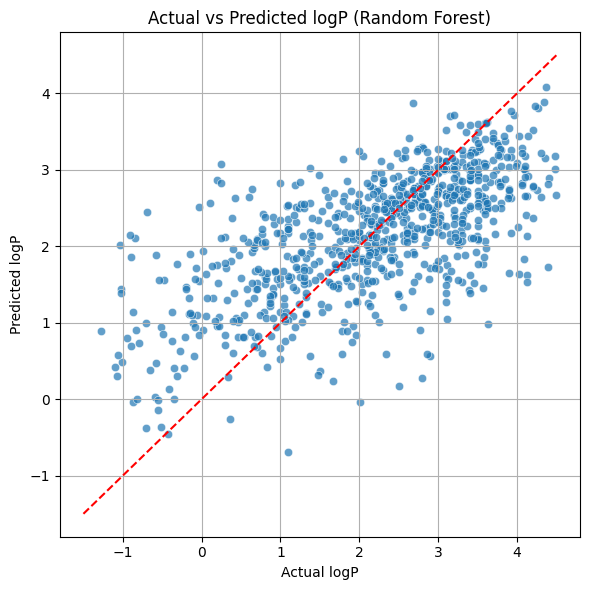

In [ ]:
plt.figure(figsize=(6,6))  # 1. Set the figure size (6x6 inches)

# 2. Plot a scatter plot of actual logP (y_test) vs predicted logP (rf_pred)
# alpha=0.7 → Add transparency to help visualize overlapping points
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.7)

# 3. Add a diagonal reference line for perfect prediction (y = x)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

# 4. Set axis labels
plt.xlabel("Actual logP")      # Actual measured values
plt.ylabel("Predicted logP")   # Predicted values from the model

# 5. Set the plot title
plt.title("Actual vs Predicted logP (Random Forest)")

# 6. Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# 7. Display the plot
plt.show()

In [ ]:
# SVR is sensitive to feature scaling, so use it with StandardScaler in a pipeline
# Define a nonlinear SVR model using the RBF kernel
svr = make_pipeline(
    StandardScaler(),         # Standardize input features (mean=0, std=1)
    SVR(kernel='rbf',         # Use RBF kernel (suitable for nonlinear regression)
        C=1.0,                # Regularization strength (higher values increase risk of overfitting)
        epsilon=0.1)          # Margin of tolerance for errors
)

# Train the model using the training data
svr.fit(X_train, y_train)

# Generate predictions on the test data
y_pred_svr = svr.predict(X_test)

# Calculate model evaluation metrics (MSE, R²)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print evaluation results
print("🔍 SVR Model Evaluation")
print("Mean Squared Error (MSE):", round(mse_svr, 4))
print("R² Score:", round(r2_svr, 4))

plt.show()

🔍 SVR Model Evaluation
Mean Squared Error (MSE): 1.0776
R² Score: 0.3329


/tmp/ipython-input-55-3492266952.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


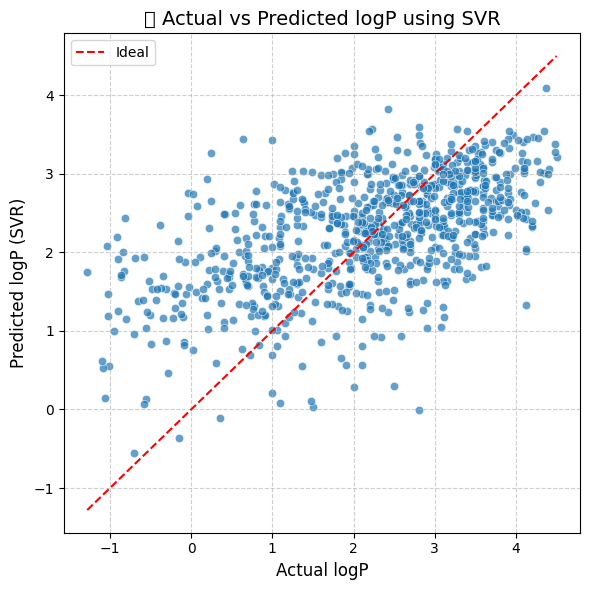

In [ ]:
# Set the figure size
plt.figure(figsize=(6,6))

# Plot a scatter plot of actual (y_test) vs predicted (y_pred_svr) values
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7)

# Plot the ideal prediction line (predicted = actual) on the diagonal (red dashed line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')

# Add axis labels and plot title
plt.xlabel("Actual logP", fontsize=12)
plt.ylabel("Predicted logP (SVR)", fontsize=12)
plt.title("📊 Actual vs Predicted logP using SVR", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Display the graph
plt.show()

In [ ]:
# Use only TPSA as the input feature
X = df[["TPSA"]]
y = df["Lipophilicity"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR (RBF kernel)": make_pipeline(StandardScaler(), SVR(kernel="rbf"))
}

# Compare model performance
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "MSE": round(mse, 4),
        "R²": round(r2, 4)
    })

# Summarize results
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("📊 Performance Comparison Using TPSA Only")
print(results_df)


📊 Performance Comparison Using TPSA Only
               Model     MSE      R²
1      Random Forest  1.4805  0.0372
0  Linear Regression  1.4999  0.0245
2   SVR (RBF kernel)  1.5306  0.0045
